In [1]:
# imports
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from Levenshtein import distance as levenshtein_distance
import numpy as np

In [2]:
pl.Config.load_from_file("../polars_cfg.json")

In [3]:
# load eval set
arc_all_tasks = pl.read_csv("../data/ARC_all_tasks_tests_stats.csv").filter(
    (pl.col("task_type") == "evaluation") & (pl.col("example_type") == "test")
)
arc_eval_tests = arc_all_tasks.select(
    "task_name",
    "example_number",
    "input_height",
    "input_width",
    "output_height",
    "output_width",
    "output_grid",
    "grid_size",
).rename({"output_grid": "true_output_grid", "example_number": "test_number"})

In [4]:
# load human / machine outputs
greenblatt = pl.read_csv("../data/kaggle_solutions/greenblatt/submission.csv")
claude3_5 = pl.read_csv("../data/kaggle_solutions/claude3_5-langchain/submission.csv")

human_two_attempt_acc = pl.read_csv("../data/mean_task_acc_two_attempts.csv")
human_two_attempt_acc_training = human_two_attempt_acc.filter(
    pl.col("task_type") == "training"
).drop("task_type")

human_two_attempt_acc_eval = human_two_attempt_acc.filter(
    pl.col("task_type") == "evaluation"
).drop("task_type")

human_eval_summary = (
    pl.read_csv("../data/clean_summary_data_merged.csv")
    .filter(pl.col("task_type") == "evaluation")
    .drop("task_type")
)
# make human acc binary
human_two_attempt_acc_eval = human_two_attempt_acc_eval.with_columns(
    human_solved=(pl.col("mean_solved") > 0.0).cast(pl.Int32)
)
human_two_attempt_acc_training = human_two_attempt_acc_training.with_columns(
    human_solved=(pl.col("mean_solved") > 0.0).cast(pl.Int32)
)

# merge with arc stuff
greenblatt = greenblatt.join(arc_eval_tests, on=["task_name", "test_number"])
claude3_5 = claude3_5.join(arc_eval_tests, on=["task_name", "test_number"])

# filter out tests that are not first
greenblatt_filtered = greenblatt.filter(pl.col("test_number") == 1)
claude3_5_filtered = claude3_5.filter(pl.col("test_number") == 1)
human_eval_summary = human_eval_summary.join(
    arc_eval_tests.filter(pl.col("test_number") == 1), on="task_name", how="left"
)

# add test_output_grid dimensions
human_eval_summary = human_eval_summary.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)
greenblatt_filtered = greenblatt_filtered.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)
claude3_5_filtered = claude3_5_filtered.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)

In [5]:
def get_model_solved(df):
    df_ = df.with_columns(
        correct=pl.col("test_output_grid").eq(pl.col("true_output_grid")).cast(pl.Int32)
    )
    # model name
    name = df.unique("submission_id").select("submission_id").item()
    df_ = df_.with_columns(
        pl.when((pl.col("correct") == 1) & (pl.col("attempt_number") == 1))
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved_one_shot"),
        pl.when((pl.col("correct") == 1) & (pl.col("attempt_number") == 2))
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved_two_shot"),
    )
    df_ = df_.group_by(["task_name", "test_number"]).agg(
        pl.sum(f"{name}_solved_one_shot").alias(f"{name}_solved_one_shot"),
        pl.sum(f"{name}_solved_two_shot").alias(f"{name}_solved_two_shot"),
    )
    df_ = df_.with_columns(
        pl.when(
            (pl.col(f"{name}_solved_one_shot") == 1)
            | (pl.col(f"{name}_solved_two_shot") == 1)
        )
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved"),
    )
    df_ = df_.select(
        "task_name",
        "test_number",
        f"{name}_solved_one_shot",
        f"{name}_solved_two_shot",
        f"{name}_solved",
    )
    # print number of unique tasks
    print(f"Number of unique tasks attempted by {name}: {df_.n_unique('task_name')}")
    return df_

In [6]:
greenblatt_solved = get_model_solved(greenblatt)
claude3_5_solved = get_model_solved(claude3_5)

Number of unique tasks attempted by greenblatt: 400
Number of unique tasks attempted by claude3_5-langchain: 150


In [7]:
# print 1 and 2 shot machine accuracy
print("1-shot accuracy")
print(50 * "-")

for model in [
    ("greenblatt", greenblatt_solved),
    ("claude3_5-langchain", claude3_5_solved),
]:
    mean_task_score = (
        model[1].group_by("task_name").agg(pl.mean(f"{model[0]}_solved_one_shot"))
    )
    num_solved = mean_task_score.filter(
        pl.col(f"{model[0]}_solved_one_shot") > 0.0
    ).height
    total = model[1].height
    print(
        f"{model[0]}: {round(mean_task_score.select(pl.mean(f'{model[0]}_solved_one_shot')).item()*100, 2)} ({num_solved}/{total} tests)"
    )

print("\n2-shot accuracy")
print(50 * "-")

for model in [
    ("greenblatt", greenblatt_solved),
    ("claude3_5-langchain", claude3_5_solved),
]:
    mean_task_score = model[1].group_by("task_name").agg(pl.mean(f"{model[0]}_solved"))
    num_solved = mean_task_score.filter(pl.col(f"{model[0]}_solved") > 0.0).height
    total = model[1].height
    print(
        f"{model[0]}: {round(mean_task_score.select(pl.mean(f'{model[0]}_solved')).item()*100, 2)} ({num_solved}/{total} tests)"
    )

1-shot accuracy
--------------------------------------------------
greenblatt: 38.5 (156/419 tests)
claude3_5-langchain: 19.33 (30/157 tests)

2-shot accuracy
--------------------------------------------------
greenblatt: 42.0 (169/419 tests)
claude3_5-langchain: 20.67 (32/157 tests)


In [8]:
# join to human data
human_greenblatt = human_two_attempt_acc_eval.join(
    greenblatt_solved.filter(pl.col("test_number") == 1), on="task_name", how="inner"
)
human_claude3_5 = human_two_attempt_acc_eval.join(
    claude3_5_solved.filter(pl.col("test_number") == 1), on="task_name", how="inner"
)
merged = human_greenblatt.join(claude3_5_solved, on="task_name", how="inner")

In [9]:
# add columns to show who solved the task
human_greenblatt = human_greenblatt.with_columns(
    pl.when((pl.col("human_solved") == 0) & (pl.col("greenblatt_solved") == 1))
    .then(pl.lit("machine_solved"))
    .when((pl.col("human_solved") == 1) & (pl.col("greenblatt_solved") == 0))
    .then(pl.lit("human_solved"))
    .when((pl.col("human_solved") == 0) & (pl.col("greenblatt_solved") == 0))
    .then(pl.lit("neither_solved"))
    .otherwise(pl.lit("both_solved"))
    .alias("solved_by"),
)

human_claude3_5 = human_claude3_5.with_columns(
    pl.when((pl.col("human_solved") == 0) & (pl.col("claude3_5-langchain_solved") == 1))
    .then(pl.lit("machine_solved"))
    .when((pl.col("human_solved") == 1) & (pl.col("claude3_5-langchain_solved") == 0))
    .then(pl.lit("human_solved"))
    .when((pl.col("human_solved") == 0) & (pl.col("claude3_5-langchain_solved") == 0))
    .then(pl.lit("neither_solved"))
    .otherwise(pl.lit("both_solved"))
    .alias("solved_by"),
)

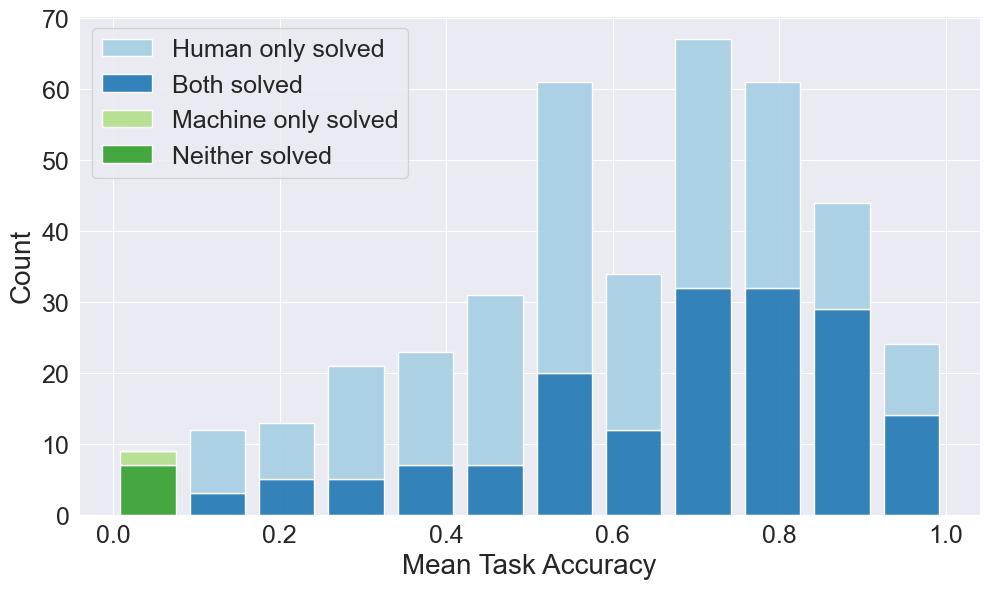

In [10]:
# plot human vs machine (greenblatt) accuracy distribution
sns.set_style("darkgrid")
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c"]
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    human_greenblatt,
    x="mean_solved",
    hue="solved_by",
    hue_order=["human_solved", "both_solved", "machine_solved", "neither_solved"],
    multiple="stack",
    palette=colors,
    shrink=0.8,
    alpha=0.9,
    ax=ax,
)
plt.xlabel("Mean Task Accuracy", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = ax.get_legend().legend_handles
labels = ["Human only solved", "Both solved", "Machine only solved", "Neither solved"]
plt.legend(handles=legend, labels=labels, fontsize=18)
total_tasks = human_greenblatt.height
plt.tight_layout()
plt.savefig(
    "../figures/human_greenblatt_accuracy_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

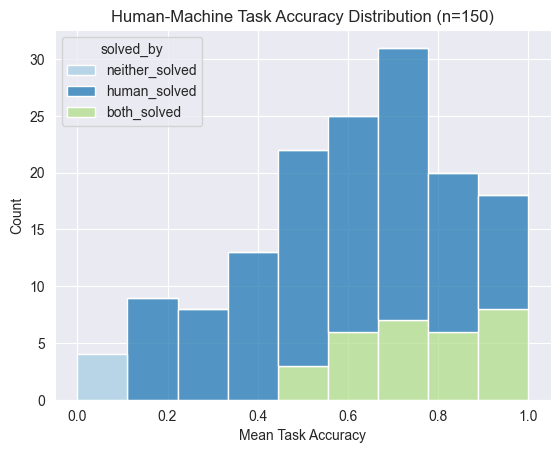

In [11]:
# plot human vs machine (claude3.5) accuracy distribution
sns.histplot(
    human_claude3_5,
    x="mean_solved",
    hue="solved_by",
    multiple="stack",
    palette="Paired",
)
plt.xlabel("Mean Task Accuracy")
total_tasks = human_claude3_5.height
plt.title(f"Human-Machine Task Accuracy Distribution (n={total_tasks})")
plt.show()

In [12]:
total_tasks_machine_only = human_greenblatt.filter(
    pl.col("solved_by") == "machine_solved"
).height
print(
    f"Number of tasks where greenblatt solved but human did not: {total_tasks_machine_only}"
)

total_tasks_human_only = human_greenblatt.filter(
    pl.col("solved_by") == "human_solved"
).height
print(
    f"Number of tasks where human solved but greenblatt did not: {total_tasks_human_only}"
)

Number of tasks where greenblatt solved but human did not: 2
Number of tasks where human solved but greenblatt did not: 225


In [13]:
# show tasks where only greenblatt solved
human_greenblatt.filter(pl.col("solved_by") == "machine_solved").sort(
    "count", descending=True
)

task_name,count,mean_solved,human_solved,test_number,greenblatt_solved_one_shot,greenblatt_solved_two_shot,greenblatt_solved,solved_by
str,i64,f64,i32,i64,i32,i32,i32,str
"""31d5ba1a.json""",9,0.0,0,1,1,0,1,"""machine_solved"""
"""4ff4c9da.json""",7,0.0,0,1,1,0,1,"""machine_solved"""


After manual inspection of the tasks solved by Greenblatt's solution but not humans, here are my observations:

1. 31d5ba1a is an XOR task which no one solves, even in three attempts.
2. The second task is a "find matching objects already identified in the grid and color them as well" task. One human solves it in three attempts.


In [14]:
total_tasks = human_claude3_5.filter(pl.col("solved_by") == "machine_solved").height
print(f"Number of tasks where claude3.5 solved but human did not: {total_tasks}")

total_tasks = human_claude3_5.filter(pl.col("solved_by") == "human_solved").height
print(f"Number of tasks where human solved but claude3.5 did not: {total_tasks}")

Number of tasks where claude3.5 solved but human did not: 0
Number of tasks where human solved but claude3.5 did not: 116


In [15]:
# show tasks only solved by humans (greenblatt)
human_greenblatt.filter(pl.col("solved_by") == "human_solved").sort(
    ["mean_solved", "count"], descending=True
).head(10)

task_name,count,mean_solved,human_solved,test_number,greenblatt_solved_one_shot,greenblatt_solved_two_shot,greenblatt_solved,solved_by
str,i64,f64,i32,i64,i32,i32,i32,str
"""b15fca0b.json""",11,1.0,1,1,0,0,0,"""human_solved"""
"""1e97544e.json""",10,1.0,1,1,0,0,0,"""human_solved"""
"""5b526a93.json""",8,1.0,1,1,0,0,0,"""human_solved"""
"""81c0276b.json""",7,1.0,1,1,0,0,0,"""human_solved"""
"""0a1d4ef5.json""",7,1.0,1,1,0,0,0,"""human_solved"""
"""5a5a2103.json""",5,1.0,1,1,0,0,0,"""human_solved"""
"""05a7bcf2.json""",5,1.0,1,1,0,0,0,"""human_solved"""
"""692cd3b6.json""",5,1.0,1,1,0,0,0,"""human_solved"""
"""ea959feb.json""",12,0.916667,1,1,0,0,0,"""human_solved"""


In [16]:
num_human_only_solved = human_greenblatt.filter(
    pl.col("solved_by") == "human_solved"
).height
print(
    f"Number of tasks where human solved but greenblatt did not: {num_human_only_solved}"
)

Number of tasks where human solved but greenblatt did not: 225


In [17]:
# show tasks solved by neither (greenblatt)
human_greenblatt.filter(pl.col("solved_by") == "neither_solved").sort(
    "count", descending=True
).head(10)

task_name,count,mean_solved,human_solved,test_number,greenblatt_solved_one_shot,greenblatt_solved_two_shot,greenblatt_solved,solved_by
str,i64,f64,i32,i64,i32,i32,i32,str
"""b4a43f3b.json""",10,0.0,0,1,0,0,0,"""neither_solved"""
"""1c56ad9f.json""",9,0.0,0,1,0,0,0,"""neither_solved"""
"""a8610ef7.json""",8,0.0,0,1,0,0,0,"""neither_solved"""
"""8719f442.json""",7,0.0,0,1,0,0,0,"""neither_solved"""
"""5b692c0f.json""",7,0.0,0,1,0,0,0,"""neither_solved"""
"""79fb03f4.json""",6,0.0,0,1,0,0,0,"""neither_solved"""
"""891232d6.json""",6,0.0,0,1,0,0,0,"""neither_solved"""


In [18]:
# show tasks solved by both (greenblatt)
human_greenblatt.filter(pl.col("solved_by") == "both_solved").sort(
    ["mean_solved", "count"], descending=[False, True]
).head(10)

task_name,count,mean_solved,human_solved,test_number,greenblatt_solved_one_shot,greenblatt_solved_two_shot,greenblatt_solved,solved_by
str,i64,f64,i32,i64,i32,i32,i32,str
"""0c9aba6e.json""",9,0.111111,1,1,1,0,1,"""both_solved"""
"""5d2a5c43.json""",8,0.125,1,1,1,0,1,"""both_solved"""
"""d56f2372.json""",7,0.142857,1,1,0,1,1,"""both_solved"""
"""84db8fc4.json""",6,0.166667,1,1,1,0,1,"""both_solved"""
"""66f2d22f.json""",11,0.181818,1,1,1,0,1,"""both_solved"""
"""195ba7dc.json""",10,0.2,1,1,1,0,1,"""both_solved"""
"""d19f7514.json""",13,0.230769,1,1,1,0,1,"""both_solved"""
"""ce039d91.json""",13,0.230769,1,1,1,0,1,"""both_solved"""
"""90347967.json""",8,0.25,1,1,1,0,1,"""both_solved"""


In [19]:
# show tasks only solved by humans (claude3.5 & greenblatt)
merged.filter(
    (pl.col("human_solved") == 1)
    & (pl.col("greenblatt_solved") == 0)
    & (pl.col("claude3_5-langchain_solved") == 0)
).sort(["mean_solved", "count"], descending=[True, True]).head(10)

task_name,count,mean_solved,human_solved,test_number,greenblatt_solved_one_shot,greenblatt_solved_two_shot,greenblatt_solved,test_number_right,claude3_5-langchain_solved_one_shot,claude3_5-langchain_solved_two_shot,claude3_5-langchain_solved
str,i64,f64,i32,i64,i32,i32,i32,i64,i32,i32,i32
"""0a1d4ef5.json""",7,1.0,1,1,0,0,0,1,0,0,0
"""5a5a2103.json""",5,1.0,1,1,0,0,0,1,0,0,0
"""05a7bcf2.json""",5,1.0,1,1,0,0,0,1,0,0,0
"""2546ccf6.json""",11,0.909091,1,1,0,0,0,1,0,0,0
"""2753e76c.json""",9,0.888889,1,1,0,0,0,1,0,0,0
"""4b6b68e5.json""",14,0.857143,1,1,0,0,0,1,0,0,0
"""5ffb2104.json""",12,0.833333,1,1,0,0,0,1,0,0,0
"""1da012fc.json""",12,0.833333,1,1,0,0,0,1,0,0,0
"""42a15761.json""",6,0.833333,1,1,0,0,0,1,0,0,0


Some observations for each task:

**2546ccf6**
Complete broken object(s) using symmetry.

**0a1d4ef5**
Easy visual task. Identify objects in noisy grid and map the color and location of each object one-to-one to a single cell in the output grid. Requires counting and identifying spatial relations.

**2697da3f**
Requires rotation and mapping to cross-like pattern in output grid.

**09c534e7**
Visual task. Requires identifying color to fill in objects with. Analogically similar to liquid filling up containers or something spreading within contained area.

**5a5a2103**
Seems relatively easy although few data points. Each row of the first column of the problem serves as a color template. An object of arbitrary color in any (meta-) cell serves as an object template. Combining these two, the participant must fill in all (meta-) cells.

**42a15761**
A counting and sorting task. Requires identifying red columns as objects, empty cells within objects as number and then sorting the columns.

**4b6b68e5**
Requires identifying color to fill in objects with and objects that can be filled (i.e., those with continuous border)

**0becf7df**
This one is not that easy. Kinda surprising that people are that good at it! There is a sort of template 2x2 square at the top left corner. Each cell in the square maps to an object in a clump of colored objects in the center. The mapping is by color. The output cell is a copy of the input cell with new coloring of each object from the input. The coloring is as follows: for each row of the template square, the corresponding objects swap colors.

**1da012fc**
Another template mapping problem.

---

Some notes:

1. Many of these tasks require identifying irregular objects. Not clear how easy it would be to write numpy code to accomplish these tasks even though it's actually pretty intuitive.
2. Pretty neat that people are good at these but not models!


In [20]:
# get hardest tasks
human_two_attempt_acc_training.sort(
    ["mean_solved", "count"], descending=[False, True]
).head(10)

task_name,count,mean_solved,human_solved
str,i64,f64,i32
"""007bbfb7.json""",11,0.0,0
"""9aec4887.json""",11,0.0,0
"""10fcaaa3.json""",7,0.0,0
"""4290ef0e.json""",5,0.0,0
"""9edfc990.json""",3,0.0,0
"""5c2c9af4.json""",3,0.0,0
"""8f2ea7aa.json""",11,0.090909,1
"""e3497940.json""",7,0.142857,1
"""3631a71a.json""",7,0.142857,1


In [21]:
# get easiest tasks
human_two_attempt_acc_training.sort(
    ["mean_solved", "count"], descending=[True, True]
).head(10)

task_name,count,mean_solved,human_solved
str,i64,f64,i32
"""e9afcf9a.json""",21,1.0,1
"""9172f3a0.json""",17,1.0,1
"""a5313dff.json""",16,1.0,1
"""f76d97a5.json""",16,1.0,1
"""3aa6fb7a.json""",16,1.0,1
"""d631b094.json""",15,1.0,1
"""d43fd935.json""",15,1.0,1
"""ea786f4a.json""",15,1.0,1
"""6150a2bd.json""",15,1.0,1


In [22]:
# compute edit distance for incorrect submission for models
greenblatt_incorrect = (
    greenblatt_filtered.filter(pl.col("test_output_grid") != pl.col("true_output_grid"))
    .with_columns(
        (
            pl.concat_list("test_output_grid", "true_output_grid").map_elements(
                lambda x: levenshtein_distance(x[0], x[1]), return_dtype=pl.Int32
            )
            / pl.col("grid_size")
        ).alias("levenshtein_distance")
    )
    .rename(
        {"output_height": "true_output_height", "output_width": "true_output_width"}
    )
)
claude3_5_incorrect = (
    claude3_5_filtered.filter(pl.col("test_output_grid") != pl.col("true_output_grid"))
    .with_columns(
        (
            pl.concat_list("test_output_grid", "true_output_grid").map_elements(
                lambda x: levenshtein_distance(x[0], x[1]), return_dtype=pl.Int32
            )
            / pl.col("grid_size")
        ).alias("levenshtein_distance")
    )
    .rename(
        {"output_height": "true_output_height", "output_width": "true_output_width"}
    )
)
human_incorrect = (
    human_eval_summary.filter(
        (pl.col("test_output_grid") != pl.col("true_output_grid"))
        & (pl.col("attempt_number") <= 2)
    )
    .with_columns(
        (
            pl.concat_list("test_output_grid", "true_output_grid").map_elements(
                lambda x: levenshtein_distance(x[0], x[1]), return_dtype=pl.Int32
            )
            / pl.col("grid_size")
        ).alias("levenshtein_distance")
    )
    .rename(
        {"output_height": "true_output_height", "output_width": "true_output_width"}
    )
)

In [23]:
# compute proportion of incorrect submissions with different output dimensions
def compute_incorrect_output_dims(df):
    df = df.with_columns(
        pl.when(
            (pl.col("true_output_height") != pl.col("test_output_height"))
            | (pl.col("true_output_width") != pl.col("test_output_width"))
        )
        .then(1)
        .otherwise(0)
        .alias("incorrect_output_dims")
    )
    return df


greenblatt_incorrect = compute_incorrect_output_dims(greenblatt_incorrect)
claude3_5_incorrect = compute_incorrect_output_dims(claude3_5_incorrect)
human_incorrect = compute_incorrect_output_dims(human_incorrect)

for name, df in [
    ("greenblatt", greenblatt_incorrect),
    ("claude_5", claude3_5_incorrect),
    ("human", human_incorrect),
]:
    num_incorrect = df.filter(pl.col("incorrect_output_dims") == 1).height
    total = df.height

    print(
        f"Proportion of incorrect submissions with wrong output dimensions ({name}): {round(num_incorrect / total * 100, 2)}%"
    )

Proportion of incorrect submissions with wrong output dimensions (greenblatt): 8.26%
Proportion of incorrect submissions with wrong output dimensions (claude_5): 10.25%
Proportion of incorrect submissions with wrong output dimensions (human): 24.86%


In [24]:
human_incorrect = human_incorrect.rename(
    {"incorrect_output_dims": "human_incorrect_output_dims"}
)
greenblatt_incorrect = greenblatt_incorrect.rename(
    {"incorrect_output_dims": "greenblatt_incorrect_output_dims"}
)
claude3_5_incorrect = claude3_5_incorrect.rename(
    {"incorrect_output_dims": "claude3_5_incorrect_output_dims"}
)

In [25]:
edit_dist_comparison = (
    human_incorrect.filter(pl.col("human_incorrect_output_dims") == 0)
    .join(
        greenblatt_incorrect.filter(pl.col("greenblatt_incorrect_output_dims") == 0)
        .select("task_name", "test_output_grid", "levenshtein_distance")
        .rename(
            {
                "test_output_grid": "greenblatt_test_output_grid",
                "levenshtein_distance": "greenblatt_levenshtein_distance",
            }
        ),
        on="task_name",
        how="inner",
    )
    .join(
        claude3_5_incorrect.filter(pl.col("claude3_5_incorrect_output_dims") == 0)
        .select("task_name", "test_output_grid", "levenshtein_distance")
        .rename(
            {
                "test_output_grid": "claude3_5_test_output_grid",
                "levenshtein_distance": "claude3_5_levenshtein_distance",
            }
        ),
        on="task_name",
        how="inner",
    )
)
edit_dist_comparison = edit_dist_comparison.group_by("task_name").agg(
    pl.mean("levenshtein_distance").alias("mean_human_levenshtein_distance"),
    pl.mean("greenblatt_levenshtein_distance").alias(
        "mean_greenblatt_levenshtein_distance"
    ),
    pl.mean("claude3_5_levenshtein_distance").alias(
        "mean_claude3_5_levenshtein_distance"
    ),
)

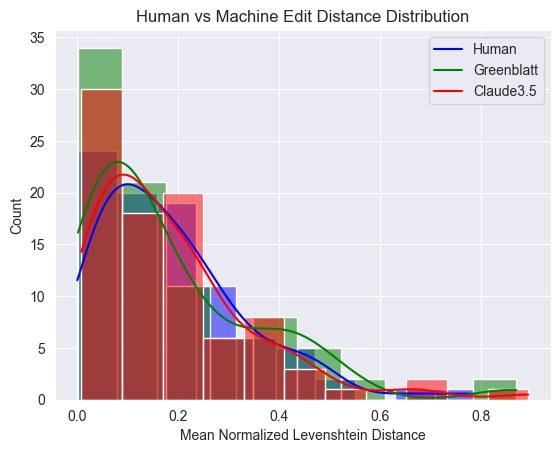

In [26]:
# plot all three models
sns.histplot(
    edit_dist_comparison, x="mean_human_levenshtein_distance", color="blue", kde=True
)
sns.histplot(
    edit_dist_comparison,
    x="mean_greenblatt_levenshtein_distance",
    color="green",
    kde=True,
)
sns.histplot(
    edit_dist_comparison, x="mean_claude3_5_levenshtein_distance", color="red", kde=True
)
plt.legend(["Human", "Greenblatt", "Claude3.5"])
plt.xlabel("Mean Normalized Levenshtein Distance")
plt.title("Human vs Machine Edit Distance Distribution")
plt.show()

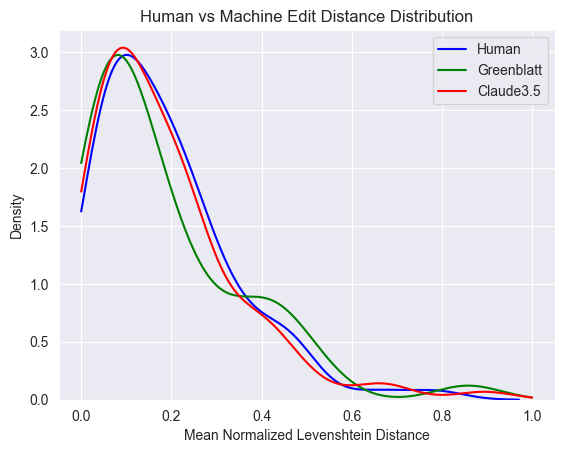

In [27]:
# plot all three models
sns.kdeplot(
    edit_dist_comparison,
    x="mean_human_levenshtein_distance",
    color="blue",
    clip=(0, 1),
)
sns.kdeplot(
    edit_dist_comparison,
    x="mean_greenblatt_levenshtein_distance",
    color="green",
    clip=(0, 1),
)
sns.kdeplot(
    edit_dist_comparison,
    x="mean_claude3_5_levenshtein_distance",
    color="red",
    clip=(0, 1),
)
plt.legend(["Human", "Greenblatt", "Claude3.5"])
plt.xlabel("Mean Normalized Levenshtein Distance")
plt.title("Human vs Machine Edit Distance Distribution")
plt.show()

In [28]:
# print mean for each model
for model in ["human", "greenblatt", "claude3_5"]:
    mean_dist = edit_dist_comparison.select(
        pl.mean(f"mean_{model}_levenshtein_distance")
    )
    std = edit_dist_comparison.select(pl.std(f"mean_{model}_levenshtein_distance"))
    print(
        f"Mean Normalized Levenshtein Distance ({model}): {round(mean_dist.item(), 4)}"
    )
    print(f"Standard Deviation ({model}): {round(std.item(), 4)}\n")

Mean Normalized Levenshtein Distance (human): 0.1891
Standard Deviation (human): 0.1503

Mean Normalized Levenshtein Distance (greenblatt): 0.1853
Standard Deviation (greenblatt): 0.1784

Mean Normalized Levenshtein Distance (claude3_5): 0.1841
Standard Deviation (claude3_5): 0.1613



In [29]:
edit_dist_comparison.sort(
    "mean_greenblatt_levenshtein_distance", descending=False
).join(
    human_two_attempt_acc_eval.select("task_name", "mean_solved"), on="task_name"
).join(
    greenblatt_solved.select("task_name", "greenblatt_solved"), on="task_name"
).sort(
    ["mean_greenblatt_levenshtein_distance", "mean_human_levenshtein_distance"],
    descending=[False, True],
)

task_name,mean_human_levenshtein_distance,mean_greenblatt_levenshtein_distance,mean_claude3_5_levenshtein_distance,mean_solved,greenblatt_solved
str,f64,f64,f64,f64,i32
"""070dd51e.json""",0.042143,0.0025,0.10625,0.583333,1
"""1e81d6f9.json""",0.077333,0.004444,0.022222,0.454545,1
"""18419cfa.json""",0.011905,0.008242,0.018544,0.5,1
"""2a5f8217.json""",0.089744,0.011834,0.097633,0.4,1
"""0e671a1a.json""",0.203156,0.017751,0.085799,0.571429,1
"""1c02dbbe.json""",0.075556,0.017778,0.268889,0.5,1
"""319f2597.json""",0.055833,0.02,0.135,0.777778,1
"""140c817e.json""",0.258503,0.020408,0.227041,0.571429,1
…,…,…,…,…,…


In [30]:
# compute edit distance between human and machine outputs that are correct dimensions
pairwise = (
    human_incorrect.filter(pl.col("human_incorrect_output_dims") == 0)
    .select("task_name", "attempt_number", "test_output_grid", "grid_size")
    .rename({"test_output_grid": "human_output_grid"})
)
pairwise = pairwise.join(
    greenblatt_incorrect.filter(
        (pl.col("test_output_grid") != pl.col("true_output_grid"))
        & pl.col("greenblatt_incorrect_output_dims")
        == 0
    )
    .select("task_name", "attempt_number", "test_output_grid")
    .rename({"test_output_grid": "greenblatt_output_grid"}),
    on=["task_name", "attempt_number"],
    how="left",
)
pairwise = pairwise.join(
    claude3_5_incorrect.filter(
        (pl.col("test_output_grid") != pl.col("true_output_grid"))
        & pl.col("claude3_5_incorrect_output_dims")
        == 0
    )
    .select("task_name", "attempt_number", "test_output_grid")
    .rename({"test_output_grid": "claude3_5_output_grid"}),
    on=["task_name", "attempt_number"],
    how="left",
).sort(["task_name", "attempt_number"])
pairwise_array = pairwise.select(
    "task_name",
    "grid_size",
    "human_output_grid",
    "greenblatt_output_grid",
    "claude3_5_output_grid",
).to_numpy()

In [32]:
pairwise_edit_distances = {
    "task_name": [],
    "human_vs_greenblatt": [],
    "human_vs_claude3_5": [],
    "greenblatt_vs_claude3_5": [],
}
for row in pairwise_array:
    pairwise_edit_distances["task_name"].append(row[0])
    for i, output1 in enumerate(row[2:]):
        for j, output2 in enumerate(row[i + 3 :]):
            if i == 0:
                if j == 1:
                    if output1 is None or output2 is None:
                        pairwise_edit_distances["human_vs_greenblatt"].append(np.nan)
                    else:
                        pairwise_edit_distances["human_vs_greenblatt"].append(
                            levenshtein_distance(output1, output2) / row[1]
                        )
                else:
                    if output1 is None or output2 is None:

                        pairwise_edit_distances["human_vs_claude3_5"].append(np.nan)
                    else:
                        pairwise_edit_distances["human_vs_claude3_5"].append(
                            levenshtein_distance(output1, output2) / row[1]
                        )
            else:
                if output1 is None or output2 is None:
                    pairwise_edit_distances["greenblatt_vs_claude3_5"].append(np.nan)
                else:
                    pairwise_edit_distances["greenblatt_vs_claude3_5"].append(
                        levenshtein_distance(output1, output2) / row[1]
                    )
pairwise_edit_distances = pl.DataFrame(pairwise_edit_distances)

In [33]:
pairwise_edit_distances = pairwise_edit_distances.group_by("task_name").agg(
    pl.col("human_vs_greenblatt").drop_nans().mean(),
    pl.col("human_vs_claude3_5").drop_nans().mean(),
    pl.col("greenblatt_vs_claude3_5").drop_nans().mean(),
)

/var/folders/zm/jsccrdtd0w1bffqvsy1bw6xr0000gn/T/ipykernel_40935/3984305752.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


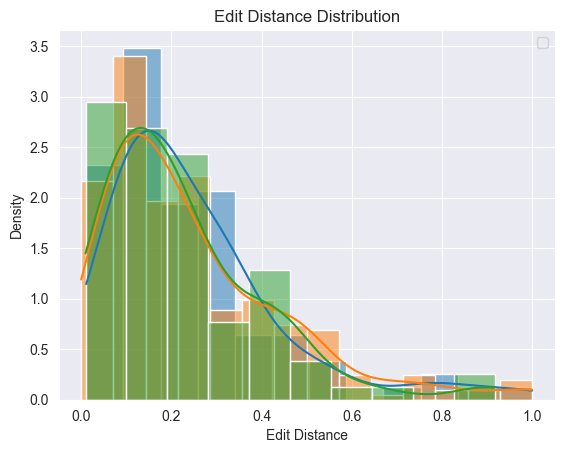

In [34]:
# plot human vs greenblatt edit distances
sns.histplot(
    pairwise_edit_distances,
    x="human_vs_greenblatt",
    kde=True,
    stat="density",
    legend=True,
)
sns.histplot(
    pairwise_edit_distances,
    x="human_vs_claude3_5",
    kde=True,
    stat="density",
    legend=True,
)
sns.histplot(
    pairwise_edit_distances,
    x="greenblatt_vs_claude3_5",
    kde=True,
    stat="density",
    legend=True,
)
legend_labels = ["Human vs Greenblatt", "Human vs Claude3.5", "Greenblatt vs Claude3.5"]
plt.legend()
plt.xlabel("Edit Distance")
plt.title("Edit Distance Distribution")
plt.show()

In [35]:
human_vs_greenblatt_mean = pairwise_edit_distances.select(
    pl.mean("human_vs_greenblatt")
).item()
human_greenblatt_std = pairwise_edit_distances.select(
    pl.std("human_vs_greenblatt")
).item()
human_vs_claude3_5_mean = pairwise_edit_distances.select(
    pl.mean("human_vs_claude3_5")
).item()
human_claude3_5_std = pairwise_edit_distances.select(
    pl.std("human_vs_claude3_5")
).item()
greenblatt_vs_claude3_5_mean = pairwise_edit_distances.select(
    pl.mean("greenblatt_vs_claude3_5")
).item()
greenblatt_vs_claude3_5_std = pairwise_edit_distances.select(
    pl.std("greenblatt_vs_claude3_5")
).item()

print(
    f"Human vs Greenblatt Edit Distance: {round(human_vs_greenblatt_mean, 4)}, std: {round(human_greenblatt_std, 4)}"
)
print(
    f"Human vs Claude3.5 Edit Distance: {round(human_vs_claude3_5_mean, 4)}, std: {round(human_claude3_5_std, 4)}"
)
print(
    f"Greenblatt vs Claude3.5 Edit Distance: {round(greenblatt_vs_claude3_5_mean, 4)}, std: {round(greenblatt_vs_claude3_5_std, 4)}"
)

Human vs Greenblatt Edit Distance: 0.2479, std: 0.1927
Human vs Claude3.5 Edit Distance: 0.2473, std: 0.2032
Greenblatt vs Claude3.5 Edit Distance: 0.2242, std: 0.1799


How much copying does either greenblatt or claude do?


In [123]:
evaluation_set = pl.read_csv("../data/ARC_evaluation_tasks.csv")
evaluation_set_train = evaluation_set.filter((pl.col("example_type") == "train"))
evaluation_set_test = evaluation_set.filter((pl.col("example_type") == "test"))
grid_agg_evaluation_train = evaluation_set_train.group_by("task_name").agg(
    pl.col("input_grid").alias("train_input_grids"),
    pl.col("output_grid").alias("train_output_grids"),
)
grid_agg_evaluation_test = evaluation_set_test.select(
    "task_name", "example_number", "input_grid", "output_grid"
).rename({"input_grid": "test_input_grid", "example_number": "test_number"})

In [126]:
def get_machine_copy_rate(df):
    df = (
        df.filter(pl.col("test_output_grid") != pl.col("true_output_grid"))
        .select("task_name", "test_output_grid", "test_number")
        .join(grid_agg_evaluation_test, on=["task_name", "test_number"], how="left")
        .join(grid_agg_evaluation_train, on="task_name", how="left")
    )
    df = df.with_columns(
        pl.col("test_output_grid")
        .is_in("train_input_grids")
        .alias("train_input_grid_copy"),
        pl.col("test_output_grid")
        .is_in("train_output_grids")
        .alias("train_output_grid_copy"),
        (pl.col("test_output_grid") == pl.col("test_input_grid")).alias(
            "test_input_grid_copy"
        ),
    )
    copy_rate_train_input = df.filter(pl.col("train_input_grid_copy")).height
    copy_rate_train_output = df.filter(pl.col("train_output_grid_copy")).height
    copy_rate_test_input = df.filter(pl.col("test_input_grid_copy")).height
    total = df.height
    return (
        copy_rate_train_input,
        copy_rate_train_output,
        copy_rate_test_input,
        total,
    )

In [128]:
greenblatt_copying = get_machine_copy_rate(greenblatt)
claude3_5_copying = get_machine_copy_rate(claude3_5)

In [136]:
print(
    f"Greenblatt Copy Rate (Train Input): {greenblatt_copying[0] / greenblatt_copying[3] * 100:.2f}%"
)
print(
    f"Greenblatt Copy Rate (Train Output): {greenblatt_copying[1] / greenblatt_copying[3] * 100:.2f}%"
)
print(
    f"Greenblatt Copy Rate (Test Input): {greenblatt_copying[2] / greenblatt_copying[3] * 100:.2f}%"
)
print(
    f"Total Greenblatt Copy Rate: {sum(greenblatt_copying[0:3])/ greenblatt_copying[3] * 100:.2f}%"
)

Greenblatt Copy Rate (Train Input): 0.00%
Greenblatt Copy Rate (Train Output): 3.51%
Greenblatt Copy Rate (Test Input): 0.00%
Total Greenblatt Copy Rate: 3.51%


In [135]:
print(
    f"Claude3.5 Copy Rate (Train Input): {claude3_5_copying[0] / claude3_5_copying[3] * 100:.2f}%"
)
print(
    f"Claude3.5 Copy Rate (Train Output): {claude3_5_copying[1] / claude3_5_copying[3] * 100:.2f}%"
)
print(
    f"Claude3.5 Copy Rate (Test Input): {claude3_5_copying[2] / claude3_5_copying[3] * 100:.2f}%"
)
print(
    f"Total Claude3.5 Copy Rate: {sum(claude3_5_copying[0:3])/ claude3_5_copying[3] * 100:.2f}%"
)

Claude3.5 Copy Rate (Train Input): 0.00%
Claude3.5 Copy Rate (Train Output): 1.18%
Claude3.5 Copy Rate (Test Input): 0.39%
Total Claude3.5 Copy Rate: 1.57%
